<a href="https://colab.research.google.com/github/wvsvenkat/MyoPS2020/blob/main/uNetMyoPS2020Incremental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Do you want to resume training from last checkpoint? (y/n): y
Resuming from checkpoints/unet_epoch50.pth
Saved checkpoint: checkpoints/unet_final.pth


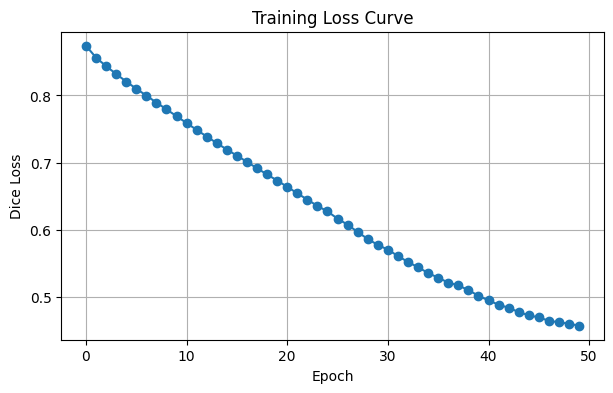

Saved validation summary to predictions/val_summary.csv


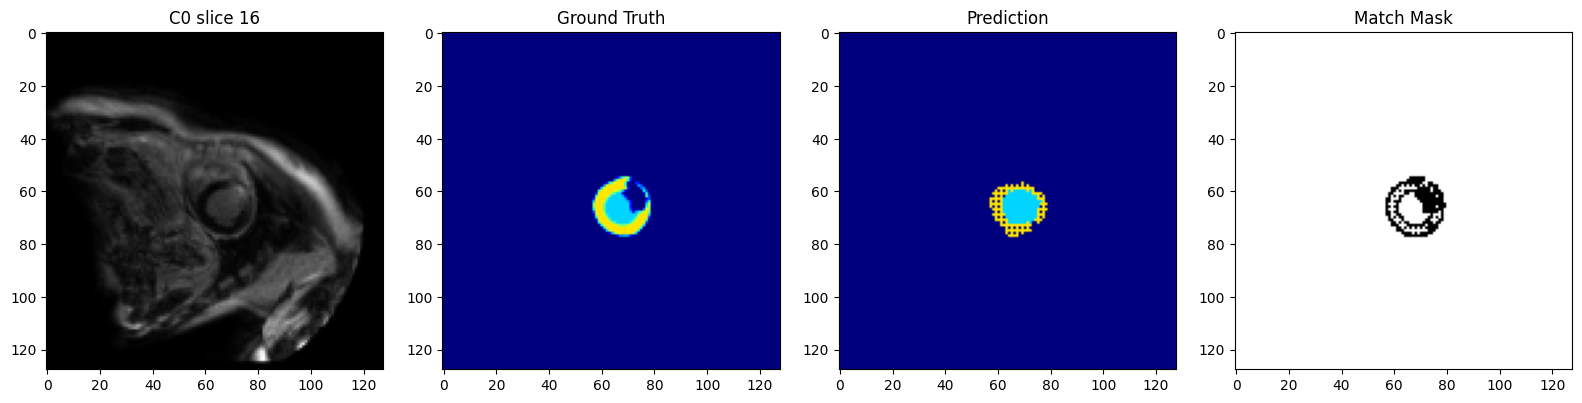

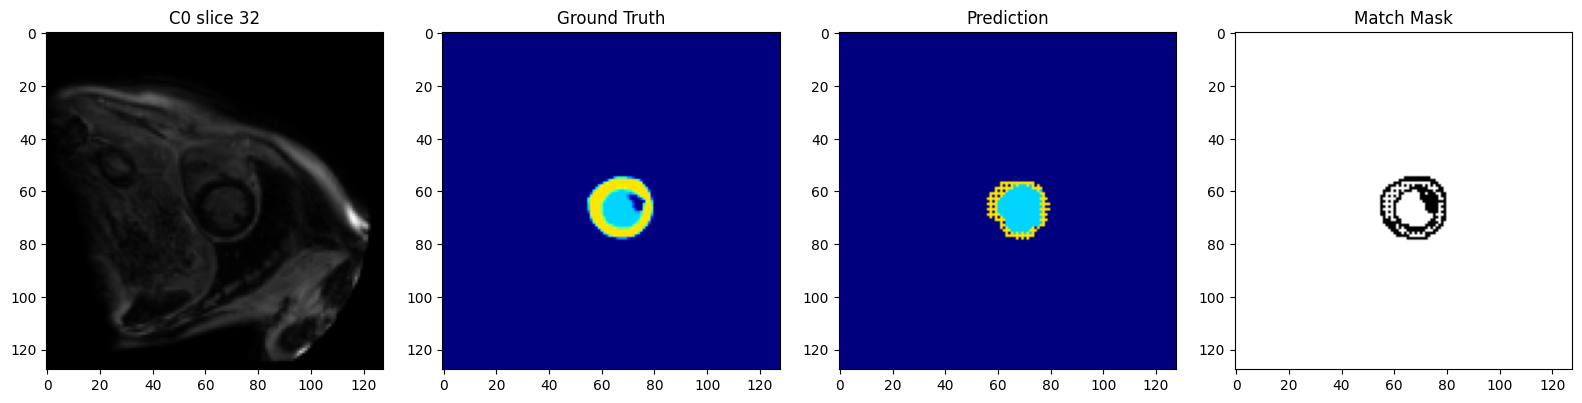

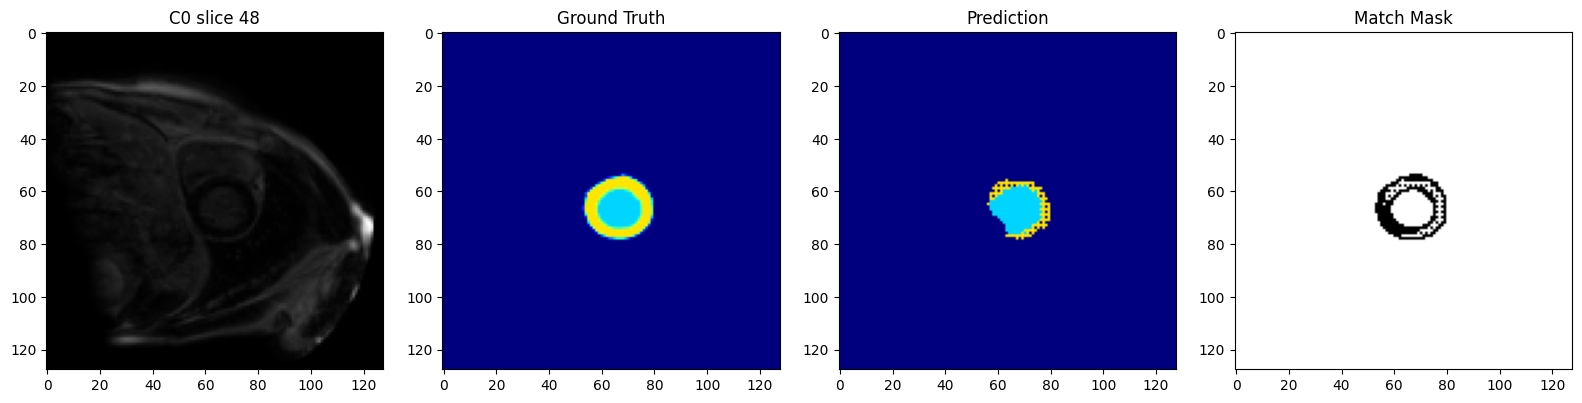

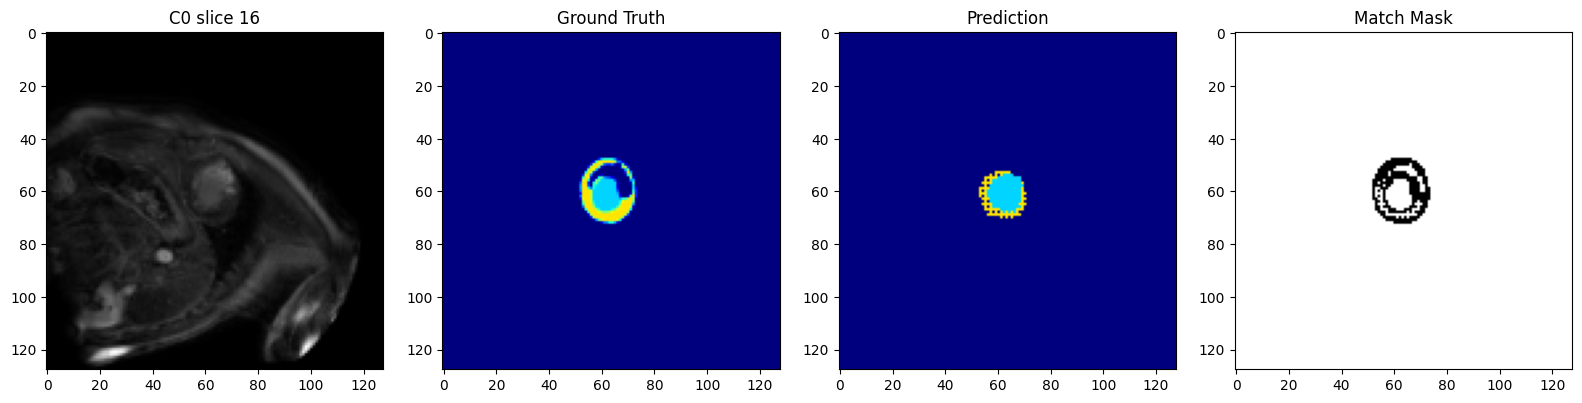

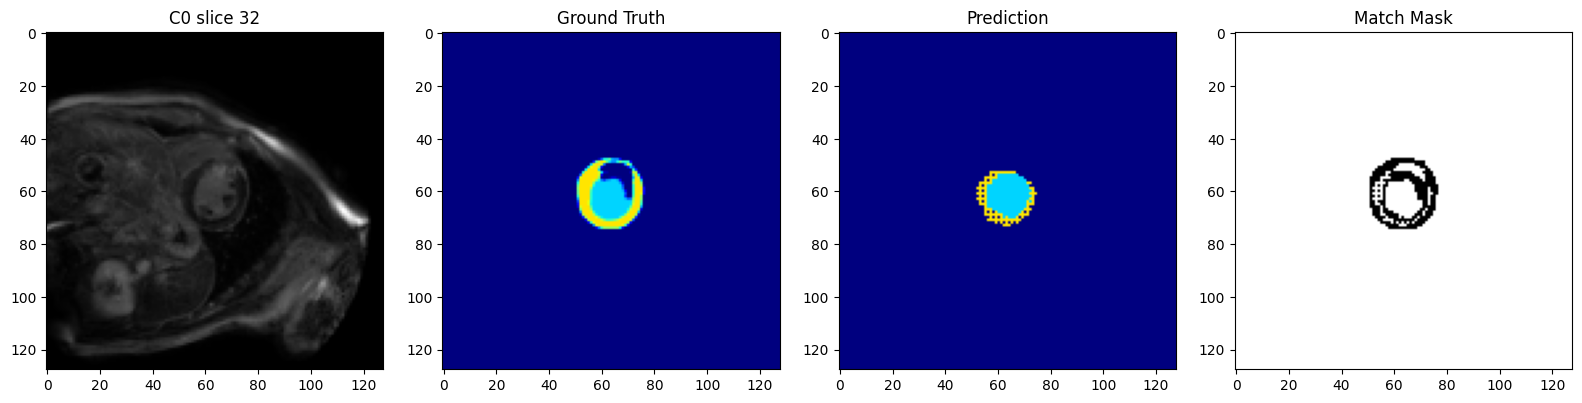

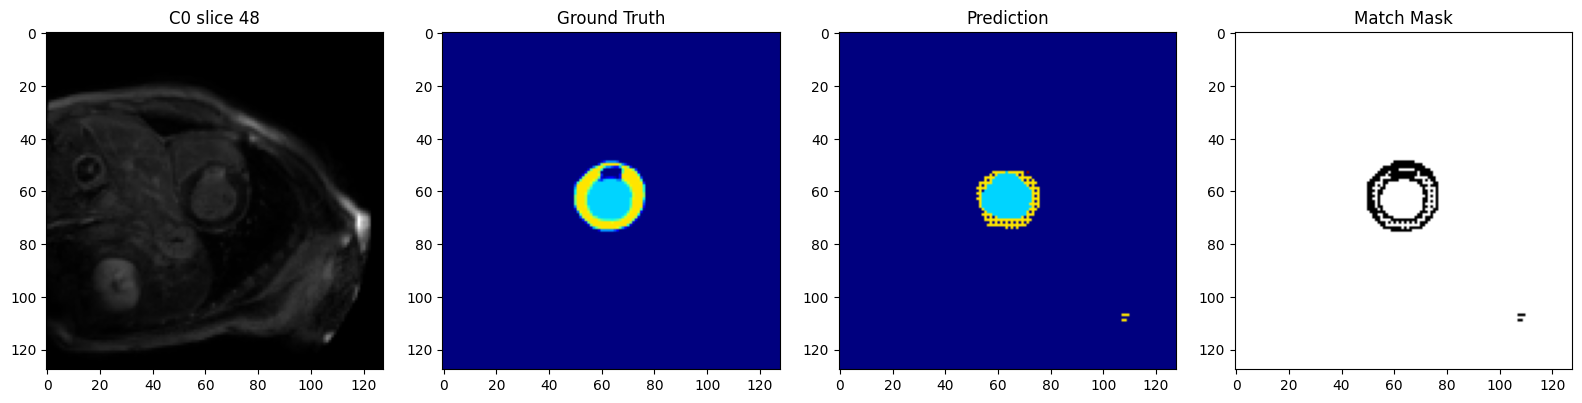

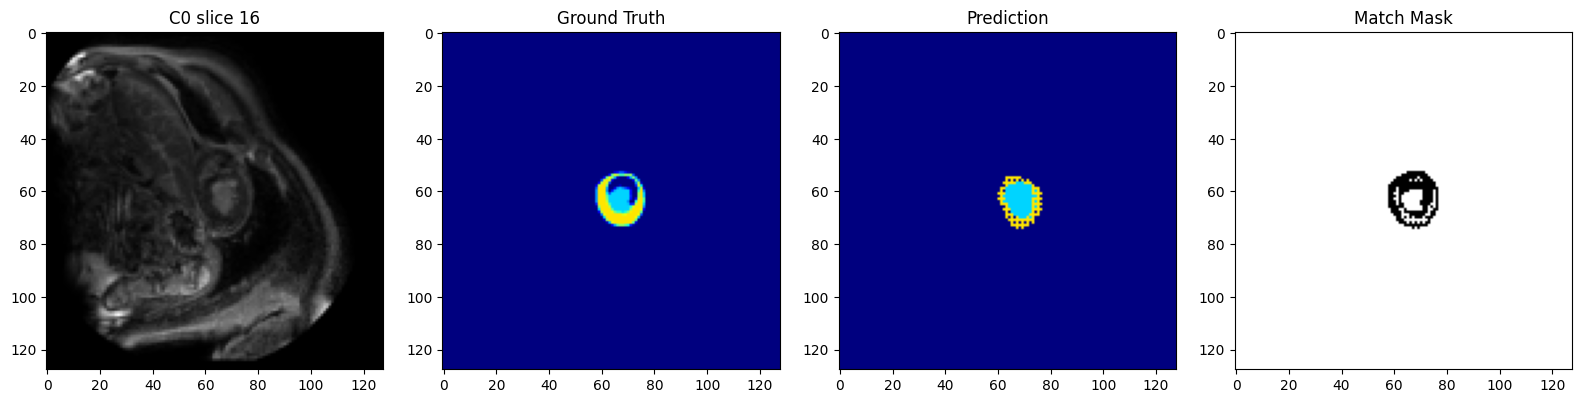

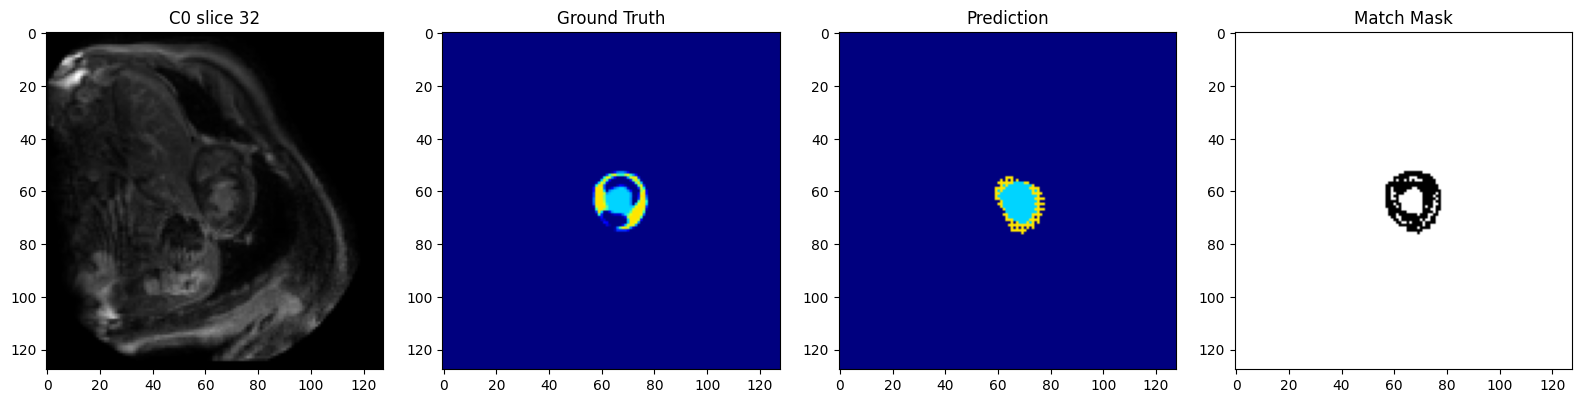

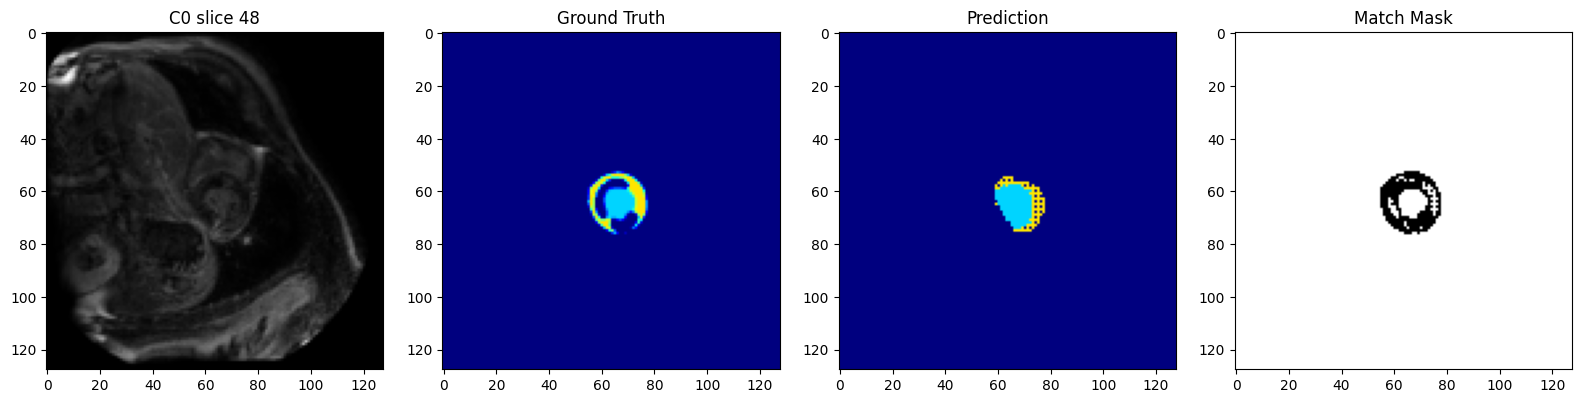

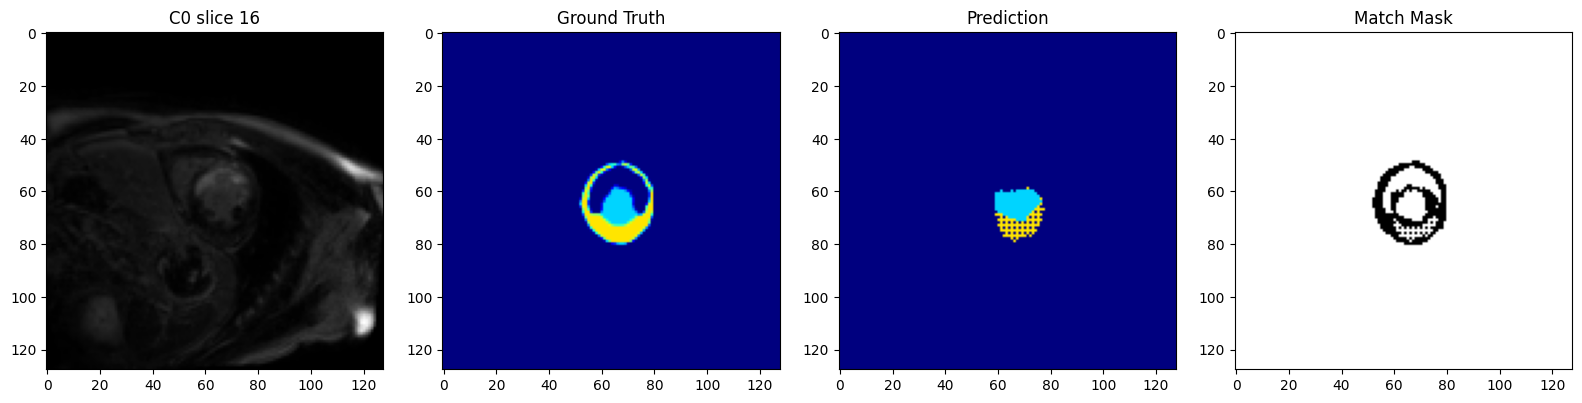

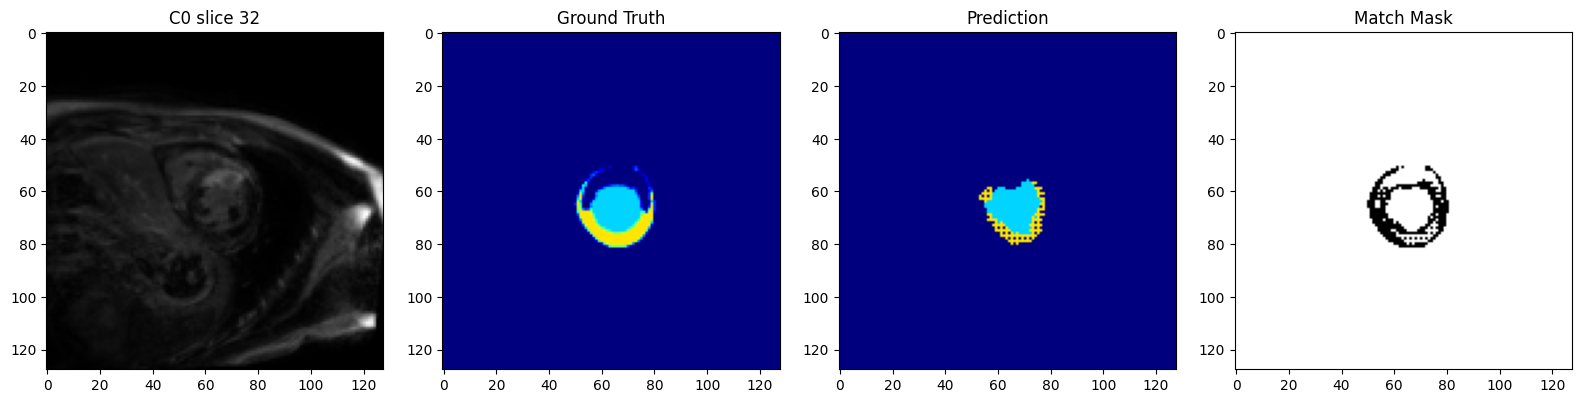

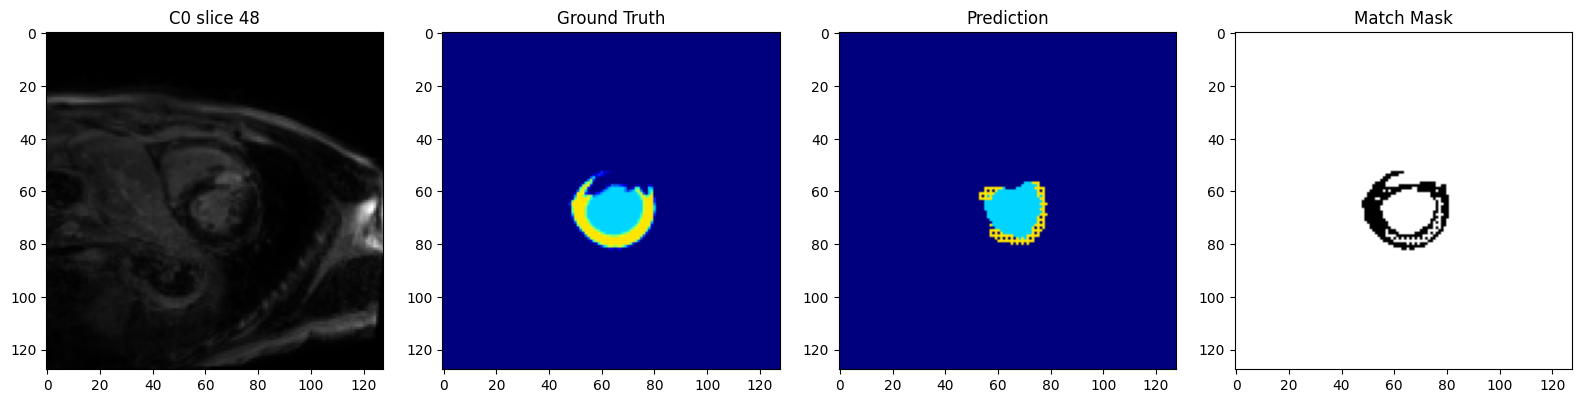

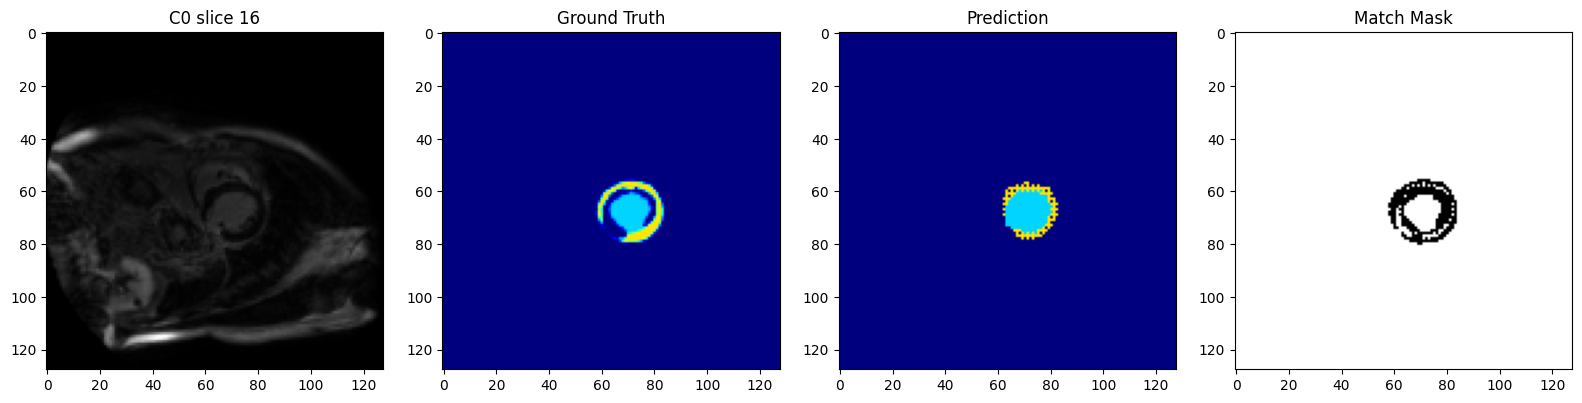

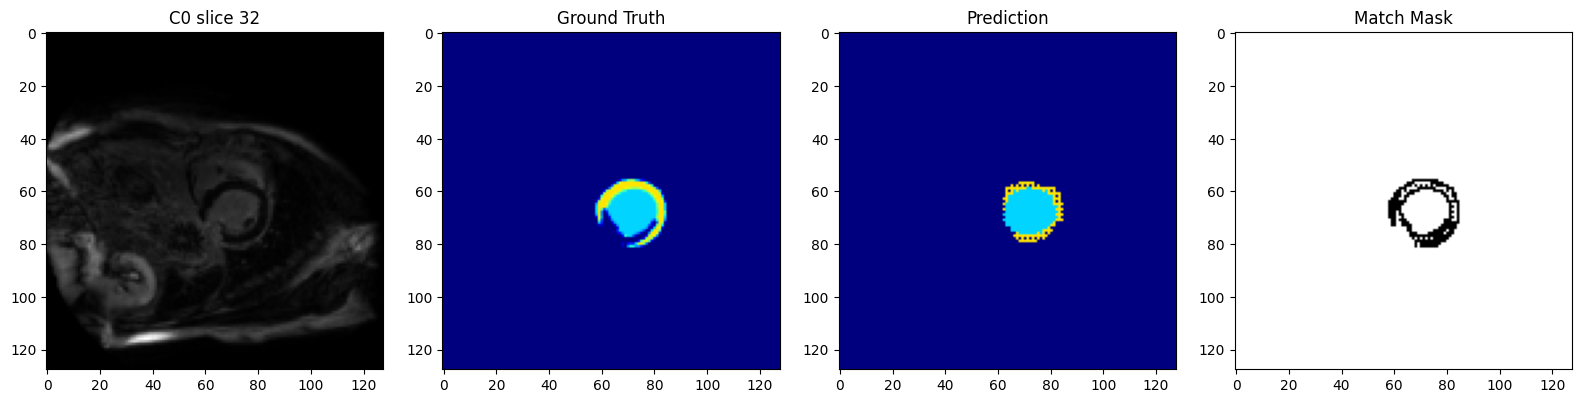

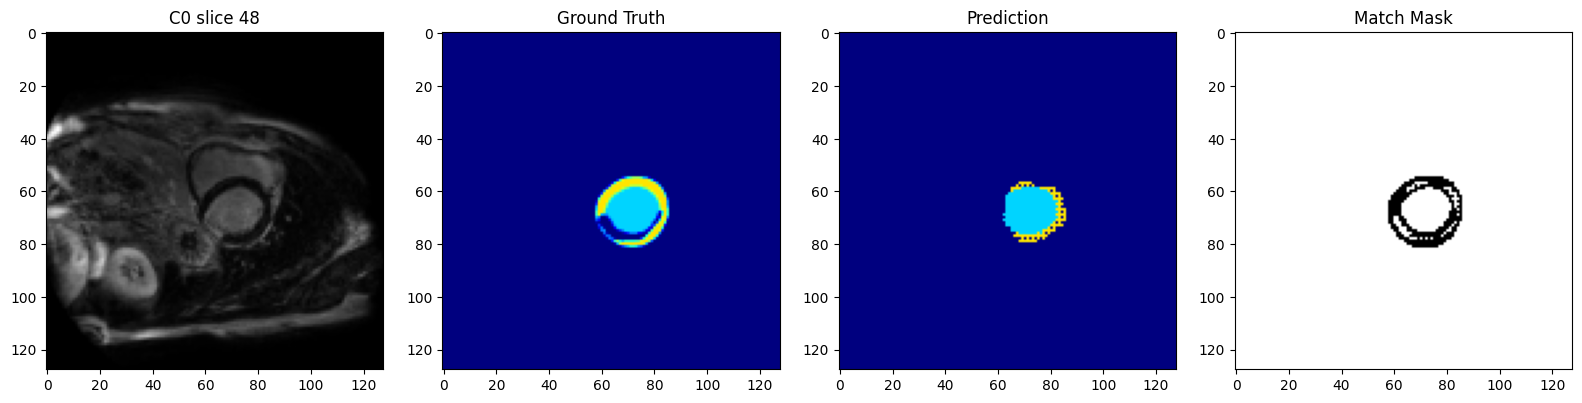

Saved Dice scores to predictions/dice_scores.csv


In [17]:
# ============================================
# 📦 Setup & Imports
# ============================================
!pip install monai nibabel pydicom pandas -q
!pip install torch torchvision torchaudio -q

import os, re, zipfile, glob
import torch
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, ScaleIntensityd, EnsureTyped,
    Resized, Compose, ConcatItemsd, Transform
)
from monai.data import Dataset
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.networks.nets import UNet

# ============================================
# 📁 Mount Google Drive & Extract Data
# ============================================
from google.colab import drive
drive.mount('/content/drive')

train_zip = "/content/drive/MyDrive/MyoPS2020/train25.zip"
gt_zip    = "/content/drive/MyDrive/MyoPS2020/train25_myops_gd.zip"

extract_path = "/content/myops_mm3d"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(train_zip, 'r') as z:
    z.extractall(extract_path + "/train")
with zipfile.ZipFile(gt_zip, 'r') as z:
    z.extractall(extract_path + "/labels")

train_root = os.path.join(extract_path, "train")
label_root = os.path.join(extract_path, "labels")
if len(os.listdir(train_root)) == 1:
    train_root = os.path.join(train_root, os.listdir(train_root)[0])
if len(os.listdir(label_root)) == 1:
    label_root = os.path.join(label_root, os.listdir(label_root)[0])

# ============================================
# 🧬 Group Files by Case & Modality
# ============================================
def list_files(root):
    exts = ("*.nii", "*.nii.gz")
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(root, "**", ext), recursive=True))
    return sorted(files)

train_files_all = list_files(train_root)
label_files_all = list_files(label_root)

def modality_of(path):
    name = os.path.basename(path).lower()
    if "_c0" in name: return "bssfp"
    if "_t2" in name: return "t2"
    if "_de" in name: return "lge"
    return None

def case_id_of(path):
    name = os.path.basename(path).lower()
    name = name.replace("_c0", "").replace("_t2", "").replace("_de", "").replace("_gd", "")
    return re.sub(r"\.nii(\.gz)?$", "", name)

cases = {}
for f in train_files_all:
    mod = modality_of(f)
    cid = case_id_of(f)
    if mod:
        cases.setdefault(cid, {})[mod] = f

labels_by_case = {case_id_of(f): f for f in label_files_all}

items = []
for cid, mods in cases.items():
    if all(k in mods for k in ["lge", "t2", "bssfp"]) and cid in labels_by_case:
        items.append({
            "lge": mods["lge"],
            "t2": mods["t2"],
            "bssfp": mods["bssfp"],
            "label": labels_by_case[cid],
            "case_id": cid
        })

# ============================================
# 🧼 Fixed Label Remapping Transform
# ============================================
class FixedRemapLabels(Transform):
    def __init__(self, mapping):
        self.mapping = mapping

    def __call__(self, data):
        label = data["label"]
        # Expect label as torch.Tensor after EnsureTyped; handle numpy too
        if isinstance(label, np.ndarray):
            label = torch.from_numpy(label)
        for orig, target in self.mapping.items():
            label[label == orig] = target
        valid_targets = torch.tensor(list(self.mapping.values()), dtype=label.dtype)
        mask = ~torch.isin(label, valid_targets)
        label[mask] = 0
        data["label"] = label
        return data

label_mapping = {0: 0, 500: 1, 200: 2, 75: 3, 60: 3}

# ============================================
# 🔄 Transforms, Dataset, DataLoader
# ============================================
target_size = (128, 128, 64)

base_transforms = Compose([
    LoadImaged(keys=["lge", "t2", "bssfp", "label"]),
    EnsureChannelFirstd(keys=["lge", "t2", "bssfp", "label"]),
    ScaleIntensityd(keys=["lge", "t2", "bssfp"]),
    FixedRemapLabels(label_mapping),
    ConcatItemsd(keys=["lge", "t2", "bssfp"], name="image", dim=0),
    Resized(keys=["image", "label"], spatial_size=target_size),
    EnsureTyped(keys=["image", "label"])
])

train_items, val_items = train_test_split(items, test_size=0.2, random_state=42)
train_ds = Dataset(data=train_items, transform=base_transforms)
val_ds   = Dataset(data=val_items, transform=base_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=1)

# ============================================
# 🧠 Model, Loss, Optimizer, Scheduler
# ============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3,
    in_channels=3,
    out_channels=4,  # background + 3 classes -> use softmax + to_onehot_y
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
).to(device)

loss_fn = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)
dice_metric = DiceMetric(include_background=False, reduction="none")

# ============================================
# 💾 Checkpoint helpers (save/load full state)
# ============================================
os.makedirs("checkpoints", exist_ok=True)

def latest_checkpoint(pattern="checkpoints/unet_epoch*.pth"):
    ckpts = sorted(glob.glob(pattern), key=lambda p: int(re.search(r"epoch(\d+)", p).group(1)) if re.search(r"epoch(\d+)", p) else -1)
    return ckpts[-1] if ckpts else None

def save_checkpoint(epoch, best_loss, patience_counter, train_losses, path):
    state = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "best_loss": best_loss,
        "patience_counter": patience_counter,
        "train_losses": train_losses,
    }
    torch.save(state, path)
    print(f"Saved checkpoint: {path}")

def load_checkpoint(path):
    state = torch.load(path, map_location=device)
    model.load_state_dict(state["model_state"])
    optimizer.load_state_dict(state["optimizer_state"])
    scheduler.load_state_dict(state["scheduler_state"])
    return state

# ============================================
# 🔁 Training with resume + validation/logging every 5 epochs
# ============================================
max_epochs = 50
train_losses = []
best_loss = float("inf")
patience_counter = 0
patience_limit = 5
val_interval = 5  # validate/save every 5 epochs

# --- Resume or restart ---
resume = input("Do you want to resume training from last checkpoint? (y/n): ").strip().lower()
start_epoch = 0
if resume == "y":
    last_ckpt = latest_checkpoint()
    if last_ckpt:
        print(f"Resuming from {last_ckpt}")
        state = load_checkpoint(last_ckpt)
        start_epoch = state["epoch"]
        best_loss = state["best_loss"]
        patience_counter = state["patience_counter"]
        train_losses = state["train_losses"]
    else:
        print("No checkpoint found, starting fresh.")
else:
    print("Starting fresh.")

class_names = ["Myocardium", "Infarction", "Edema"]
val_history_rows = []  # accumulates per-epoch (every 5) mean dice and val loss

for epoch in range(start_epoch, max_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in train_loader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{max_epochs} - Train Loss: {avg_loss:.4f}")

    # --- Save checkpoint every val_interval epochs ---
    if (epoch + 1) % val_interval == 0:
        ckpt_path = f"checkpoints/unet_epoch{epoch+1}.pth"
        save_checkpoint(epoch + 1, best_loss, patience_counter, train_losses, ckpt_path)

    # --- Validation every val_interval epochs ---
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0.0
        dice_rows = []
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch["image"].to(device), batch["label"].to(device)
                outputs = model(images)
                val_loss += loss_fn(outputs, labels).item()
                # per-batch per-class Dice
                dice_scores = dice_metric(y_pred=outputs, y=labels).cpu().numpy().flatten()
                row = {name: float(dice_scores[i]) for i, name in enumerate(class_names)}
                dice_rows.append(row)
        val_loss /= len(val_loader)
        mean_dice = float(np.nanmean([np.mean(list(r.values())) for r in dice_rows]))
        print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}, Mean Dice: {mean_dice:.3f}")

        # Log per-epoch validation summary
        val_history_rows.append({
            "epoch": epoch + 1,
            "val_loss": val_loss,
            "mean_dice": mean_dice,
            **{f"dice_{name}": float(np.mean([r[name] for r in dice_rows])) for name in class_names}
        })

        # LR schedule on validation loss
        scheduler.step(val_loss)

        # Early stopping logic on val loss
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print("Early stopping triggered.")
                break

# ============================================
# 💾 Save Final Model (terminal snapshot)
# ============================================
final_ckpt = "checkpoints/unet_final.pth"
save_checkpoint(epoch + 1, best_loss, patience_counter, train_losses, final_ckpt)

# ============================================
# 📉 Plot Training Loss Curve
# ============================================
plt.figure(figsize=(7,4))
plt.plot(train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Dice Loss")
plt.grid(True)
plt.show()

# ============================================
# 📒 Save validation summary CSV (every 5 epochs)
# ============================================
os.makedirs("predictions", exist_ok=True)
val_summary_path = "predictions/val_summary.csv"
pd.DataFrame(val_history_rows).to_csv(val_summary_path, index=False)
print(f"Saved validation summary to {val_summary_path}")

# ============================================
# 🧪 Final validation pass: Dice logging + visualization + NIfTI export
# ============================================
model.eval()
dice_rows = []
class_names = ["Myocardium", "Infarction", "Edema"]

with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        case_id = batch["case_id"][0]
        outputs = model(images)

        # Dice per class for this case
        dice_scores = dice_metric(y_pred=outputs, y=labels).cpu().numpy().flatten()
        valid_scores = [s for s in dice_scores if not np.isnan(s)]
        if valid_scores:
            row = {name: float(s if not np.isnan(s) else 0.0) for i, s in enumerate(dice_scores)}
            dice_rows.append(row)
        dice_row = {"case_id": case_id}
        for i, name in enumerate(class_names):
            dice_row[name] = float(dice_scores[i])
        dice_rows.append(dice_row)

        # Save prediction as NIfTI (argmax over classes)
        pred = torch.argmax(outputs, dim=1)[0].cpu().numpy()
        affine = np.eye(4)
        nib.save(nib.Nifti1Image(pred.astype(np.uint8), affine), f"predictions/{case_id}_pred.nii.gz")

        # Visualization: multiple slices
        img_np = images[0].cpu().numpy()  # shape [C, H, W, D]
        lbl_np = labels[0,0].cpu().numpy()  # single channel label [H, W, D]
        slice_indices = [img_np.shape[-1]//4, img_np.shape[-1]//2, 3*img_np.shape[-1]//4]
        for z in slice_indices:
            plt.figure(figsize=(16,4))
            plt.subplot(1,4,1); plt.imshow(img_np[0, ..., z], cmap="gray"); plt.title(f"C0 slice {z}")
            plt.subplot(1,4,2); plt.imshow(lbl_np[..., z], cmap="jet", vmin=0, vmax=3); plt.title("Ground Truth")
            plt.subplot(1,4,3); plt.imshow(pred[..., z], cmap="jet", vmin=0, vmax=3); plt.title("Prediction")
            match_mask = (lbl_np[..., z] == pred[..., z]).astype(np.uint8) * 255
            plt.subplot(1,4,4); plt.imshow(match_mask, cmap="gray"); plt.title("Match Mask")
            plt.tight_layout()
            plt.show()

# Save per-case Dice scores to CSV
df = pd.DataFrame(dice_rows)
df["MeanDice"] = df[class_names].mean(axis=1)
dice_path = "predictions/dice_scores.csv"
df.to_csv(dice_path, index=False)
print(f"Saved Dice scores to {dice_path}")